In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np 
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [8]:
# checking for GPU availability
from keras import backend as K
print(K._get_available_gpus())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import sys


print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

[]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1426561919969062195
xla_global_id: -1
]
Python Platform: macOS-13.5-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.11.3 (main, Apr 19 2023, 18:49:55) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.3.0
SciPy 1.10.1
GPU is NOT AVAILABLE


In [9]:
window_size=700

In [10]:
# # prep functions for input into model


def fill_time(time):
    """
    This snippet was taken almost directly from lightkurve fill_gaps source code
    Takes an array of times, finds any gaps and returns a gapless time array
    
    Parameters
    ----------
    time : array
        Array times to fill gaps within
        
    Returns
    -------
    ntime : array
        Array of times with gaps filled
    """
    dt = np.nanmedian(time[1::] - time[:-1:])
    ntime = [time[0]]
    for t in time[1::]:
        prevtime = ntime[-1]
        while (t - prevtime) > 1.2 * dt: # why 1.2?
            ntime.append(prevtime + dt)
            prevtime = ntime[-1]
        ntime.append(t)
    return np.asarray(ntime, float)


def fill_gaps(time, ntime, attr, zeros=False):
    """
    Adapted from lightkurve fill_gaps source code
    This is kind of janky, could just have a wrapper for fill_time 
    where if attr is none than we just fill time
    and if attr is an actual array we fill time and the gaps in the attribute
    the only thing is it's repetitively calling fill_time 
    whereas now it just takes an output from fill_time every time it's called
    
    Parameters
    ----------
    time : array
        Original array of times without gaps filled in
    ntime : array
        Filled array of times
    attr : array
        Original array of some values defined at `time` times
        
        
    Returns
    -------
    nattr : array
        Array of values with length ntime
    """
    in_original = np.in1d(ntime, time)
    nattr = np.zeros(len(ntime)) # initialize new attribute array
    nattr[in_original] = np.copy(attr) # copy input array
    if zeros == False:
        nattr[~in_original] = np.interp(ntime[~in_original], time, attr)
    else:
        nattr[~in_original] = 0
    return nattr


def pad(attr, window_size=window_size, zeros=False):
    """
    Parameters
    ----------
    attr : array
        Array to pad
    window_size : int
        Total number of points to pad attr by,
        with window_size // 2 points on each end
    zeros : bool
        Pad with zeros if True. 
        Default is to pad with the first and last values of attr
        
    Returns
    -------
         : array
        Padded array of values
    """
    if zeros == False:
        attr_left = np.full((window_size//2,), attr[0])
        attr_right = np.full((window_size//2,), attr[-1])
        return np.hstack([attr_left, attr, attr_right])
    elif zeros == True:
        padding = np.full((window_size//2,), 0)
        return np.hstack([padding, attr, padding])
    else:
        return ValueError("That is not a valid entry for the `zeros` parameter. Please enter True or False")


In [11]:
def prep_for_generator(target_data, fname=None, window_size=window_size):
    # here fnames is a list of filenames to read in
    flux_list = []
    label_list = []
    centroid_list = []
    poscorr_list = []
    cr_list = []
    # print('loading in data')
    #for file in fnames:
    # print(file)
    #target_data = np.load(file, allow_pickle=True).T
    #     data=[self.lc_time, self.lc.flux.value, self.lc.flux_err.value, self.lc.quality.value, self.pos_corr, self.c_dist, self.crArr]
    lc_time = target_data[0]
    lc_flux = target_data[-1] # injected flux array
    
#       lc_ferr = target_data[2] # flux error
    lc_quality = target_data[3] # quality
    lc_poscorr = target_data[4] # pos corr
    lc_cdist = target_data[5] # magnitude of centroid shift
    lc_crArr = target_data[6] # cosmic ray array
    lc_flareArr = target_data[-2] # flare array
    lc_flux = np.nan_to_num(lc_flux, np.nanmedian(lc_flux))
    lc_poscorr = np.nan_to_num(lc_poscorr, 0)
    lc_cdist = np.nan_to_num(lc_cdist, 0)
    lc_crArr = np.nan_to_num(lc_crArr, 0)
    lc_flareArr = np.nan_to_num(lc_flareArr, 0)
#     plt.plot(lc_time[:5000], lc_flux[:5000])
#     plt.plot(lc_time[:1000], lc_poscorr[:1000])
#     plt.plot(lc_time[:1000], lc_cdist[:1000])
#     plt.plot(lc_time[:5000], lc_flareArr[:5000])
#     plt.show()
#         print(lc_flux)
    # print('getting nan indices')
    # nan_indices = np.where(np.isnan(lc_time) | np.isnan(lc_flux) | np.isnan(lc_quality) | np.isnan(lc_poscorr) | np.isnan(lc_cdist) | np.isnan(lc_crArr) | np.isnan(lc_flareArr) )[0]
    # # # print(nan_indices)
    # # a=100
    # # k=200
    # # plt.plot(lc_time[:k], np.nan_to_num(lc_flux[:k], nan=0))
    # # plt.plot(lc_time[:k]+1, lc_flux[:k]+1)
    # # plt.plot(lc_time[:k], np.full(k,0))
    # print('getting rid of nans')
    # lc_time = lc_time[~nan_indices]
    # lc_flux = lc_flux[~nan_indices]
    # lc_quality = lc_quality[~nan_indices]
    # lc_poscorr = lc_poscorr[~nan_indices]
    # lc_cdist = lc_cdist[~nan_indices]
    # lc_crArr = lc_crArr[~nan_indices]
    # lc_flareArr= lc_flareArr[~nan_indices]

    # print('filling gaps')
    # fill gaps
    ntime = fill_time(lc_time)
    nflux = fill_gaps(lc_time, ntime, lc_flux)
    ncentroid = fill_gaps(lc_time, ntime, lc_cdist)
    nposcorr = fill_gaps(lc_time, ntime, lc_poscorr)
    ncr = fill_gaps(lc_time, ntime, lc_crArr)
#         print('orig num of flare pts', len(flareArr[flareArr==1]), 'out of a total of', len(flareArr))
    labels = fill_gaps(lc_time, ntime, lc_flareArr, zeros=True)
#         print('filled num fluxes', len(nflux))
#         print('filled num labels', len(labels))

    # print('padding')
    # pad the LC
    nflux = pad(nflux, window_size=window_size)
    labels = pad(labels, window_size=window_size, zeros=True)
    ncentroid = pad(ncentroid, window_size=window_size)
    nposcorr = pad(nposcorr, window_size=window_size)
    ncr = pad(ncr, window_size=window_size, zeros=True)

#         fig, ax = plt.subplots(2, sharex=True)
#         ax[0].plot(nflux[-100:])
#         ax[1].plot(labels[-100:])
   
    if fname is not None:
        root = str(fname).split('/')
        root = root[-1]
        df = pd.DataFrame(data=[ntime, nflux, nposcorr, ncentroid, ncr, labels]).T
        np.save('/Users/veraberger/nasa/filled_padded_data/'+root, np.asarray(df))

    label_list.append(labels)
    flux_list.append(nflux)
    centroid_list.append(ncentroid)
    poscorr_list.append(nposcorr)
    cr_list.append(ncr)
#         print(len(label_list))
#         print(len(flux_list))
#     print('plotting')
#     plt.figure(figsize=(10, 8))
#     k = 500
#     plotflux = nflux[440:k]
#     plottime = ntime[440:k]
#     plt.plot(plottime, plotflux, color='black')
# #         print('final num of flare pts', len(labels[labels==1]))
# #         print('final num of nonflare pts', len(labels[labels==0]))
#     plt.plot(plottime[labels[440:k]==1], plotflux[labels[440:k]==1], color='red', marker='o', ls='none', markersize=2)
#     plt.show()
    print(' fluxes', len(flux_list), 'labels', len(label_list), 'centroid', len(centroid_list), 'poscorr', len(poscorr_list))
#     print(flux_list, label_list, centroid_list, poscorr_list, cr_list)
    return flux_list, label_list, centroid_list, poscorr_list, cr_list


 fluxes 1 labels 1 centroid 1 poscorr 1
1


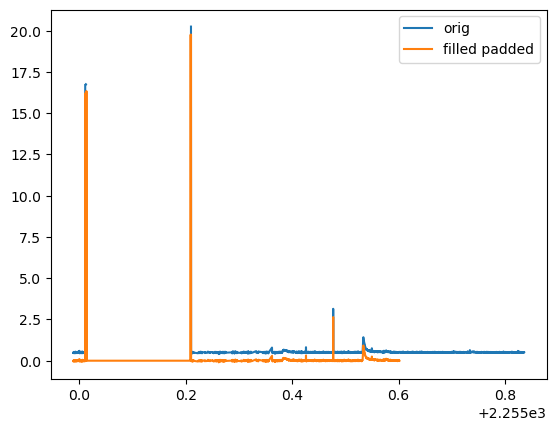

In [12]:
fname = '/Users/veraberger/nasa/training_data/29830830_35_1_data.npy'
# fname = '/Users/veraberger/nasa/training_data/257004995_47_1_data.npy'
x = np.load(fname).T
t=x[0]
ntime = fill_time(t)
ntime = pad(ntime)

# plt.plot(x[0][:1000], x[-1][:1000])

k = 3000
# print(x[0].min(), ntime.min())

# np.any(np.isnan(x[1]))
flux_list, label_list, centroid_list, poscorr_list, cr_list = prep_for_generator(x)
print(len(flux_list))

# np.any(np.isnan(flux_list))


plt.plot(x[0][:k], x[-1][:k]+.5, label='orig')
plt.plot(ntime[:k], np.asarray(flux_list).flatten()[:k], label='filled padded')
plt.legend()
plt.show()

In [13]:

def multiple_training_data_generator(file_list, batch_size=32, window_size=window_size, drop_frac=0.5,  train=True):
    for file in file_list:
        print(file)
        target_data = np.load(file, allow_pickle=True).T
        #print(target_data)
        lc_list, label_list, centroid_list, poscorr_list, cr_list = prep_for_generator(target_data, file)
        i = 0
#         print('length of lc list', len(lc_list))
        while i < len(lc_list):
            target_lc = lc_list[i]
            centroid_lc = centroid_list[i]
            poscorr_lc = poscorr_list[i]
            cr_lc = cr_list[i]
            labels = label_list[i] # flare array

            lc_length = len(target_lc)
            valid_indices = np.arange(int(window_size/2), int(lc_length-window_size/2), dtype=int)

            if train == True:
                valid_indices = np.random.choice(valid_indices, size=round(len(valid_indices)/*drop_frac), replace=False)  
            else:
                raise NotImplementedError
            j = 0 #J loops through the time series for a single target
            while j+batch_size <= len(valid_indices):
                data = np.empty((batch_size, window_size, 1))
                data2 = np.empty((batch_size, window_size, 1))
                data_poscorr = np.empty((batch_size, window_size, 1))
                data_cr = np.empty((batch_size, window_size, 1))
                
                label = np.empty((batch_size), dtype=int)
                
                for k in range(batch_size):
#                     print(i, j, k)
                    X = target_lc[valid_indices[j+k]-int(window_size/2) : valid_indices[j+k]+int(window_size/2)].reshape(window_size,1)
                    data[k,] = RobustScaler().fit_transform(X)
                    
                    label[k] = np.asarray(labels[valid_indices[j+k]])
#                     label[k] = np.asarray(labels[j+k])
#                     print('all labels', labels)
#                     print('len all labels', len(labels))
#                     print('max label', labels.max())
#                     print('these labels', labels[j+k])
#                     print('j+k', j+k)

                    X2 = centroid_lc[valid_indices[j+k]-int(window_size/2) : valid_indices[j+k]+int(window_size/2)].reshape(window_size,1)
                    data2[k,] = RobustScaler().fit_transform(X2)
                    
                    X3 = poscorr_lc[valid_indices[j+k]-int(window_size/2) : valid_indices[j+k]+int(window_size/2)].reshape(window_size,1)
                    data_poscorr[k,] = RobustScaler().fit_transform(X3)
                    
                    X4 = cr_lc[valid_indices[j+k]-int(window_size/2) : valid_indices[j+k]+int(window_size/2)].reshape(window_size,1)
                    data_cr[k,] = RobustScaler().fit_transform(X4)
                    

#                     if label[k] == 0:
#                         print(label)
#                         print(j+k)
#                         print(valid_indices[j+k])
# 
#                         plt.plot(data[k], color='black')
# #                         plt.plot(data_poscorr[k]-3, color='c')
# #                         plt.plot(data2[k]+5, color='g')
# #                         plt.plot(data_cr[k], color='y')
#                         plt.axvline(window_size/2, color='black')
#                         plt.plot(label[k], c='r')
# #                         print('label[k]', label[k])
#                         plt.plot(labels[valid_indices[j+k]-int(window_size/2) : valid_indices[j+k]+int(window_size/2)], c='r')
#                         plt.ylim(-2,10)
#                         plt.show()

        
                yield {"inputA":data, "inputB":data2, "inputC":data_poscorr, "inputD":data_cr}, label
                j = j + batch_size
            i = i + 1

In [14]:
import glob
file_list = glob.glob('/Users/veraberger/nasa/training_data/*')
len(file_list)

846

In [15]:
test_data = multiple_training_data_generator(file_list, batch_size=32, window_size=window_size)
test_data

<generator object multiple_training_data_generator at 0x295d37a60>

In [16]:
num = 0
for data, label in test_data:
    print(data['inputA'].shape, data['inputB'].shape, data['inputC'].shape, data['inputD'].shape, label.shape)
    print(label, "<--Labels")
    print()
    num = num + 1
    if num > 5: break

/Users/veraberger/nasa/training_data/TIC 270526492_48_2_data.npy
 fluxes 1 labels 1 centroid 1 poscorr 1
(32, 700, 1) (32, 700, 1) (32, 700, 1) (32, 700, 1) (32,)
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] <--Labels

(32, 700, 1) (32, 700, 1) (32, 700, 1) (32, 700, 1) (32,)
[1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] <--Labels

(32, 700, 1) (32, 700, 1) (32, 700, 1) (32, 700, 1) (32,)
[0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0] <--Labels

(32, 700, 1) (32, 700, 1) (32, 700, 1) (32, 700, 1) (32,)
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1] <--Labels

(32, 700, 1) (32, 700, 1) (32, 700, 1) (32, 700, 1) (32,)
[0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0] <--Labels

(32, 700, 1) (32, 700, 1) (32, 700, 1) (32, 700, 1) (32,)
[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1] <--Labels



In [17]:
# Define a basic ML that we can use to make sure we know the data is being imported correctly
def basic_model():
    # There is 1 input light curve. In this case, we're just looking at the flux 1D time series
    inputA = keras.layers.Input(shape=(window_size,1), name='inputA')
    inputB = keras.layers.Input(shape=(window_size,1), name='inputB')
    inputC = keras.layers.Input(shape=(window_size,1), name='inputC')
    inputD = keras.layers.Input(shape=(window_size,1), name='inputD')
    print(inputB)
    print(inputA)


    # Convolutions on the first lightcurve
    # Many components, like number of layers, filters, kernel_size, etc can be tuned
    # One way to do this is to set up a grid of possibilities and try out different models
    # check out https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputA)
    A = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(A)
    A = keras.layers.MaxPooling1D(pool_size=3, strides=2)(A)
    A = keras.layers.Dropout(0.2)(A)
    # A = keras.layers.Conv1D(filters=64, kernel_size=6, padding="causal", activation='relu')(A)
    # A = keras.layers.MaxPooling1D(pool_size=3, strides=2)(A)
    # A = keras.layers.Dropout(0.2)(A) # incr if overfitting
    A = keras.layers.Flatten()(A)
    A = keras.models.Model(inputA, A)
    # prob up kernel size
    # look at size of data at every layer in summary
    # want to reduce data

    B = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputB)
    B = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(B)
    B = keras.layers.MaxPooling1D(pool_size=3, strides=2)(B)
    B = keras.layers.Dropout(0.2)(B)
    B = keras.layers.Flatten()(B)
    B = keras.models.Model(inputB, B)
    
    C = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputC)
    C = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(C)
    C = keras.layers.MaxPooling1D(pool_size=3, strides=2)(C)
    C = keras.layers.Dropout(0.2)(C)
    C = keras.layers.Flatten()(C)
    C = keras.models.Model(inputC, C)

    D = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(inputD)
    D = keras.layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation='relu')(D)
    D = keras.layers.MaxPooling1D(pool_size=3, strides=2)(D)
    D = keras.layers.Dropout(0.2)(D)
    D = keras.layers.Flatten()(D)
    D = keras.models.Model(inputD, D)

    
    # Combine the two convolution branches before entering the dense neural network layers
    combined = keras.layers.concatenate([A.output, B.output, C.output, D.output])
#     combined=A.output

    # Final convolutional layers to make the prediction
    # Note that the final layer has an output shape of 1. This is because it will be a single prediction between 0 and 1
    F = keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(combined) # look at size of input to this layer, if smaller than 512 maybe make 512 smaller. look at what stella does too
    F = keras.layers.Dropout(0.2)(F)
    F = keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(F)
    F = keras.layers.Dropout(0.2)(F)
    F = keras.layers.Dense(1, activation='sigmoid')(F)


    multi_layer_model = keras.models.Model(inputs=(inputA, inputB, inputC, inputD), outputs=(F))

    multi_layer_model.compile(
    optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    )
    return multi_layer_model

In [18]:
model = basic_model()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 700, 1), dtype=tf.float32, name='inputB'), name='inputB', description="created by layer 'inputB'")
KerasTensor(type_spec=TensorSpec(shape=(None, 700, 1), dtype=tf.float32, name='inputA'), name='inputA', description="created by layer 'inputA'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputA (InputLayer)            [(None, 700, 1)]     0           []                               
                                                                                                  
 inputB (InputLayer)            [(None, 700, 1)]     0           []                               
                                                                                                  
 inputC (InputLayer)            [(None, 700, 1)]     0           []                               


In [27]:
# from keras.models import load_model 
# reconst_model = load_model('modelmon/model.h5')

In [28]:
dataset = tf.data.Dataset.from_generator(multiple_training_data_generator, args=[file_list[:75], window_size],
                                         output_types = ({"inputA": tf.int32, "inputB": tf.int32, "inputC": tf.int32, "inputD": tf.int32}, tf.float32),
                                            output_shapes = ({"inputA":(None,window_size,1),"inputB":(None,window_size,1),"inputC":(None,window_size,1), "inputD":(None,window_size,1)},(None,)))

In [29]:
dataset

<_FlatMapDataset element_spec=({'inputA': TensorSpec(shape=(None, 700, 1), dtype=tf.int32, name=None), 'inputB': TensorSpec(shape=(None, 700, 1), dtype=tf.int32, name=None), 'inputC': TensorSpec(shape=(None, 700, 1), dtype=tf.int32, name=None), 'inputD': TensorSpec(shape=(None, 700, 1), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [30]:
file_list[:75]

['/Users/veraberger/nasa/training_data/TIC 270526492_48_2_data.npy',
 '/Users/veraberger/nasa/training_data/177310181_28_2_data.npy',
 '/Users/veraberger/nasa/training_data/281634912_31_1_data.npy',
 '/Users/veraberger/nasa/training_data/141810080_64_2_data.npy',
 '/Users/veraberger/nasa/training_data/267484897_47_2_data.npy',
 '/Users/veraberger/nasa/training_data/TIC 307780535_64_1_data.npy',
 '/Users/veraberger/nasa/training_data/TIC 41089555_64_2_data.npy',
 '/Users/veraberger/nasa/training_data/230127302_41_1_data.npy',
 '/Users/veraberger/nasa/training_data/293271232_32_2_data.npy',
 '/Users/veraberger/nasa/training_data/294205275_27_1_data.npy',
 '/Users/veraberger/nasa/training_data/307785290_32_2_data.npy',
 '/Users/veraberger/nasa/training_data/TIC 231815113_34_1_data.npy',
 '/Users/veraberger/nasa/training_data/150393049_34_2_data.npy',
 '/Users/veraberger/nasa/training_data/TIC 138469142_52_2_data.npy',
 '/Users/veraberger/nasa/training_data/284195833_29_1_data.npy',
 '/Use

In [31]:
history = model.fit(dataset, epochs=10)#, use_multiprocessing=True)

Epoch 1/10


2023-08-09 11:06:50.758233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-09 11:06:50.785204: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


b'/Users/veraberger/nasa/training_data/TIC 270526492_48_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
     38/Unknown - 34s 863ms/step - loss: 0.0215 - accuracy: 0.9922b'/Users/veraberger/nasa/training_data/177310181_28_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
     73/Unknown - 66s 879ms/step - loss: 0.2920 - accuracy: 0.9439b'/Users/veraberger/nasa/training_data/281634912_31_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
    112/Unknown - 100s 883ms/step - loss: 0.2383 - accuracy: 0.9458b'/Users/veraberger/nasa/training_data/141810080_64_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
    151/Unknown - 135s 881ms/step - loss: 0.2293 - accuracy: 0.9412b'/Users/veraberger/nasa/training_data/267484897_47_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
    191/Unknown - 170s 882ms/step - loss: 0.2064 - accuracy: 0.9449b'/Users/veraberger/nasa/training_data/TIC 307780535_64_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
    212/Unknown - 188s 881ms/step -

 fluxes 1 labels 1 centroid 1 poscorr 1
   1837/Unknown - 1622s 882ms/step - loss: 0.1989 - accuracy: 0.9286b'/Users/veraberger/nasa/training_data/237100197_54_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
   1875/Unknown - 1655s 882ms/step - loss: 0.1988 - accuracy: 0.9285b'/Users/veraberger/nasa/training_data/156463865_40_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
   1917/Unknown - 1692s 882ms/step - loss: 0.1964 - accuracy: 0.9293b'/Users/veraberger/nasa/training_data/198409739_47_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
   1957/Unknown - 1727s 882ms/step - loss: 0.1935 - accuracy: 0.9303b'/Users/veraberger/nasa/training_data/TIC 55363662_62_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
   1995/Unknown - 1760s 881ms/step - loss: 0.1948 - accuracy: 0.9300b'/Users/veraberger/nasa/training_data/293271581_31_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
   2034/Unknown - 1794s 881ms/step - loss: 0.1983 - accuracy: 0.9282b'/Users/veraberger/nasa/trai

 fluxes 1 labels 1 centroid 1 poscorr 1
 671/2882 [=====>........................] - ETA: 32:27 - loss: 0.1982 - accuracy: 0.9281b'/Users/veraberger/nasa/training_data/TIC 141527965_34_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 708/2882 [======>.......................] - ETA: 31:55 - loss: 0.1960 - accuracy: 0.9285b'/Users/veraberger/nasa/training_data/TIC 278594030_38_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 746/2882 [======>.......................] - ETA: 31:21 - loss: 0.1999 - accuracy: 0.9265b'/Users/veraberger/nasa/training_data/TIC 177310181_31_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 785/2882 [=======>......................] - ETA: 30:47 - loss: 0.2012 - accuracy: 0.9259b'/Users/veraberger/nasa/training_data/TIC 341816971_53_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 822/2882 [=======>......................] - ETA: 30:14 - loss: 0.2037 - accuracy: 0.9241b'/Users/veraberger/nasa/training_data/TIC 150322340_30_2_data.npy'
 fluxes 1 label

2301/2882 [======================>.......] - ETA: 8:33 - loss: 0.1650 - accuracy: 0.9383b'/Users/veraberger/nasa/training_data/TIC 231091547_36_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2337/2882 [=======================>......] - ETA: 8:01 - loss: 0.1650 - accuracy: 0.9384b'/Users/veraberger/nasa/training_data/177116487_36_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2374/2882 [=======================>......] - ETA: 7:28 - loss: 0.1657 - accuracy: 0.9382b'/Users/veraberger/nasa/training_data/TIC 300242735_62_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2412/2882 [========================>.....] - ETA: 6:55 - loss: 0.1672 - accuracy: 0.9377b'/Users/veraberger/nasa/training_data/300808454_36_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2449/2882 [========================>.....] - ETA: 6:23 - loss: 0.1673 - accuracy: 0.9376b'/Users/veraberger/nasa/training_data/341490108_36_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2485/2882 [=====================

 fluxes 1 labels 1 centroid 1 poscorr 1
1012/2882 [=========>....................] - ETA: 27:39 - loss: 0.1692 - accuracy: 0.9370b'/Users/veraberger/nasa/training_data/300703521_61_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1069/2882 [==========>...................] - ETA: 26:48 - loss: 0.1643 - accuracy: 0.9390b'/Users/veraberger/nasa/training_data/TIC 306779124_33_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1106/2882 [==========>...................] - ETA: 26:15 - loss: 0.1643 - accuracy: 0.9390b'/Users/veraberger/nasa/training_data/334299463_40_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1148/2882 [==========>...................] - ETA: 25:37 - loss: 0.1623 - accuracy: 0.9397b'/Users/veraberger/nasa/training_data/TIC 89328464_35_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1172/2882 [===========>..................] - ETA: 25:15 - loss: 0.1605 - accuracy: 0.9403b'/Users/veraberger/nasa/training_data/TIC 55478693_34_2_data.npy'
 fluxes 1 labels 1 centro

 fluxes 1 labels 1 centroid 1 poscorr 1
2653/2882 [==========================>...] - ETA: 3:22 - loss: 0.1425 - accuracy: 0.9473b'/Users/veraberger/nasa/training_data/219757430_57_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2683/2882 [==========================>...] - ETA: 2:55 - loss: 0.1417 - accuracy: 0.9476b'/Users/veraberger/nasa/training_data/150144415_38_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2723/2882 [===========================>..] - ETA: 2:20 - loss: 0.1404 - accuracy: 0.9480b'/Users/veraberger/nasa/training_data/278779899_36_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2760/2882 [===========================>..] - ETA: 1:47 - loss: 0.1391 - accuracy: 0.9485b'/Users/veraberger/nasa/training_data/220411843_64_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2803/2882 [============================>.] - ETA: 1:09 - loss: 0.1383 - accuracy: 0.9489b'/Users/veraberger/nasa/training_data/TIC 271723402_33_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscor

 fluxes 1 labels 1 centroid 1 poscorr 1
1371/2882 [=============>................] - ETA: 22:12 - loss: 0.1419 - accuracy: 0.9487b'/Users/veraberger/nasa/training_data/TIC 159212711_59_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1431/2882 [=============>................] - ETA: 21:18 - loss: 0.1437 - accuracy: 0.9481b'/Users/veraberger/nasa/training_data/142110261_31_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1530/2882 [==============>...............] - ETA: 19:51 - loss: 0.1376 - accuracy: 0.9503b'/Users/veraberger/nasa/training_data/319259194_31_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1564/2882 [===============>..............] - ETA: 19:22 - loss: 0.1362 - accuracy: 0.9509b'/Users/veraberger/nasa/training_data/230092485_59_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1583/2882 [===============>..............] - ETA: 19:06 - loss: 0.1355 - accuracy: 0.9511b'/Users/veraberger/nasa/training_data/177308364_62_2_data.npy'
 fluxes 1 labels 1 centroid 1 p

 fluxes 1 labels 1 centroid 1 poscorr 1
 112/2882 [>.............................] - ETA: 41:29 - loss: 0.1363 - accuracy: 0.9464b'/Users/veraberger/nasa/training_data/141810080_64_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 151/2882 [>.............................] - ETA: 40:40 - loss: 0.1434 - accuracy: 0.9448b'/Users/veraberger/nasa/training_data/267484897_47_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 191/2882 [>.............................] - ETA: 39:55 - loss: 0.1336 - accuracy: 0.9496b'/Users/veraberger/nasa/training_data/TIC 307780535_64_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 212/2882 [=>............................] - ETA: 39:34 - loss: 0.1291 - accuracy: 0.9512b'/Users/veraberger/nasa/training_data/TIC 41089555_64_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 251/2882 [=>............................] - ETA: 38:56 - loss: 0.1294 - accuracy: 0.9514b'/Users/veraberger/nasa/training_data/230127302_41_1_data.npy'
 fluxes 1 labels 1 centroid 

1697/2882 [================>.............] - ETA: 17:58 - loss: 0.1150 - accuracy: 0.9592b'/Users/veraberger/nasa/training_data/271723402_37_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1733/2882 [=================>............] - ETA: 17:25 - loss: 0.1134 - accuracy: 0.9597b'/Users/veraberger/nasa/training_data/167526213_35_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1757/2882 [=================>............] - ETA: 17:03 - loss: 0.1124 - accuracy: 0.9601b'/Users/veraberger/nasa/training_data/TIC 277301936_38_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1795/2882 [=================>............] - ETA: 16:27 - loss: 0.1121 - accuracy: 0.9602b'/Users/veraberger/nasa/training_data/TIC 199666369_49_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1835/2882 [==================>...........] - ETA: 15:50 - loss: 0.1137 - accuracy: 0.9598b'/Users/veraberger/nasa/training_data/237100197_54_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1873/2882 [================

 407/2882 [===>..........................] - ETA: 36:55 - loss: 0.0996 - accuracy: 0.9638b'/Users/veraberger/nasa/training_data/TIC 231815113_34_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 444/2882 [===>..........................] - ETA: 36:30 - loss: 0.1264 - accuracy: 0.9586b'/Users/veraberger/nasa/training_data/150393049_34_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 481/2882 [====>.........................] - ETA: 36:10 - loss: 0.1295 - accuracy: 0.9564b'/Users/veraberger/nasa/training_data/TIC 138469142_52_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 516/2882 [====>.........................] - ETA: 35:53 - loss: 0.1281 - accuracy: 0.9568b'/Users/veraberger/nasa/training_data/284195833_29_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 556/2882 [====>.........................] - ETA: 35:22 - loss: 0.1226 - accuracy: 0.9588b'/Users/veraberger/nasa/training_data/TIC 306894095_33_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 593/2882 [=====>......

1995/2882 [===================>..........] - ETA: 13:03 - loss: 0.0965 - accuracy: 0.9666b'/Users/veraberger/nasa/training_data/293271581_31_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2034/2882 [====================>.........] - ETA: 12:28 - loss: 0.0979 - accuracy: 0.9660b'/Users/veraberger/nasa/training_data/TIC 294783597_64_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2077/2882 [====================>.........] - ETA: 11:50 - loss: 0.0971 - accuracy: 0.9663b'/Users/veraberger/nasa/training_data/155633373_41_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2115/2882 [=====================>........] - ETA: 11:16 - loss: 0.0971 - accuracy: 0.9663b'/Users/veraberger/nasa/training_data/25155310_29_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2152/2882 [=====================>........] - ETA: 10:43 - loss: 0.0967 - accuracy: 0.9664b'/Users/veraberger/nasa/training_data/233006203_57_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2182/2882 [=====================

 708/2882 [======>.......................] - ETA: 31:31 - loss: 0.1048 - accuracy: 0.9647b'/Users/veraberger/nasa/training_data/TIC 278594030_38_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 746/2882 [======>.......................] - ETA: 30:58 - loss: 0.1048 - accuracy: 0.9645b'/Users/veraberger/nasa/training_data/TIC 177310181_31_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 785/2882 [=======>......................] - ETA: 30:24 - loss: 0.1046 - accuracy: 0.9644b'/Users/veraberger/nasa/training_data/TIC 341816971_53_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 822/2882 [=======>......................] - ETA: 29:51 - loss: 0.1048 - accuracy: 0.9641b'/Users/veraberger/nasa/training_data/TIC 150322340_30_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 862/2882 [=======>......................] - ETA: 29:20 - loss: 0.1050 - accuracy: 0.9638b'/Users/veraberger/nasa/training_data/38515329_34_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 899/2882 [========>

2337/2882 [=======================>......] - ETA: 7:53 - loss: 0.0816 - accuracy: 0.9720b'/Users/veraberger/nasa/training_data/177116487_36_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2374/2882 [=======================>......] - ETA: 7:21 - loss: 0.0818 - accuracy: 0.9718b'/Users/veraberger/nasa/training_data/TIC 300242735_62_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2412/2882 [========================>.....] - ETA: 6:48 - loss: 0.0826 - accuracy: 0.9716b'/Users/veraberger/nasa/training_data/300808454_36_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2449/2882 [========================>.....] - ETA: 6:16 - loss: 0.0828 - accuracy: 0.9715b'/Users/veraberger/nasa/training_data/341490108_36_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2485/2882 [========================>.....] - ETA: 5:44 - loss: 0.0824 - accuracy: 0.9717b'/Users/veraberger/nasa/training_data/140997242_28_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2522/2882 [=========================

1069/2882 [==========>...................] - ETA: 26:57 - loss: 0.0849 - accuracy: 0.9711b'/Users/veraberger/nasa/training_data/TIC 306779124_33_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1106/2882 [==========>...................] - ETA: 26:25 - loss: 0.0847 - accuracy: 0.9711b'/Users/veraberger/nasa/training_data/334299463_40_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1148/2882 [==========>...................] - ETA: 25:47 - loss: 0.0836 - accuracy: 0.9715b'/Users/veraberger/nasa/training_data/TIC 89328464_35_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1172/2882 [===========>..................] - ETA: 25:26 - loss: 0.0826 - accuracy: 0.9718b'/Users/veraberger/nasa/training_data/TIC 55478693_34_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1209/2882 [===========>..................] - ETA: 24:53 - loss: 0.0809 - accuracy: 0.9724b'/Users/veraberger/nasa/training_data/TIC 38510324_62_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1247/2882 [===========

2653/2882 [==========================>...] - ETA: 3:23 - loss: 0.0712 - accuracy: 0.9757b'/Users/veraberger/nasa/training_data/219757430_57_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2683/2882 [==========================>...] - ETA: 2:57 - loss: 0.0707 - accuracy: 0.9759b'/Users/veraberger/nasa/training_data/150144415_38_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2723/2882 [===========================>..] - ETA: 2:21 - loss: 0.0702 - accuracy: 0.9761b'/Users/veraberger/nasa/training_data/278779899_36_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2760/2882 [===========================>..] - ETA: 1:48 - loss: 0.0696 - accuracy: 0.9763b'/Users/veraberger/nasa/training_data/220411843_64_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2803/2882 [============================>.] - ETA: 1:10 - loss: 0.0691 - accuracy: 0.9764b'/Users/veraberger/nasa/training_data/TIC 271723402_33_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
2840/2882 [=========================

1431/2882 [=============>................] - ETA: 21:09 - loss: 0.0723 - accuracy: 0.9756b'/Users/veraberger/nasa/training_data/142110261_31_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1530/2882 [==============>...............] - ETA: 19:44 - loss: 0.0692 - accuracy: 0.9766b'/Users/veraberger/nasa/training_data/319259194_31_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1564/2882 [===============>..............] - ETA: 19:15 - loss: 0.0685 - accuracy: 0.9768b'/Users/veraberger/nasa/training_data/230092485_59_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1583/2882 [===============>..............] - ETA: 18:58 - loss: 0.0681 - accuracy: 0.9770b'/Users/veraberger/nasa/training_data/177308364_62_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1623/2882 [===============>..............] - ETA: 18:24 - loss: 0.0680 - accuracy: 0.9770b'/Users/veraberger/nasa/training_data/138469142_60_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1663/2882 [================>.......

  73/2882 [..............................] - ETA: 42:16 - loss: 0.0835 - accuracy: 0.9712b'/Users/veraberger/nasa/training_data/281634912_31_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 112/2882 [>.............................] - ETA: 41:37 - loss: 0.0720 - accuracy: 0.9749b'/Users/veraberger/nasa/training_data/141810080_64_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 151/2882 [>.............................] - ETA: 41:00 - loss: 0.0788 - accuracy: 0.9726b'/Users/veraberger/nasa/training_data/267484897_47_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 191/2882 [>.............................] - ETA: 40:22 - loss: 0.0740 - accuracy: 0.9746b'/Users/veraberger/nasa/training_data/TIC 307780535_64_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 212/2882 [=>............................] - ETA: 40:03 - loss: 0.0711 - accuracy: 0.9758b'/Users/veraberger/nasa/training_data/TIC 41089555_64_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
 251/2882 [=>...............

1699/2882 [================>.............] - ETA: 17:42 - loss: 0.0602 - accuracy: 0.9801b'/Users/veraberger/nasa/training_data/271723402_37_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1735/2882 [=================>............] - ETA: 17:10 - loss: 0.0595 - accuracy: 0.9803b'/Users/veraberger/nasa/training_data/167526213_35_2_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1759/2882 [=================>............] - ETA: 16:48 - loss: 0.0590 - accuracy: 0.9804b'/Users/veraberger/nasa/training_data/TIC 277301936_38_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1797/2882 [=================>............] - ETA: 16:14 - loss: 0.0588 - accuracy: 0.9805b'/Users/veraberger/nasa/training_data/TIC 199666369_49_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1837/2882 [==================>...........] - ETA: 15:38 - loss: 0.0597 - accuracy: 0.9802b'/Users/veraberger/nasa/training_data/237100197_54_1_data.npy'
 fluxes 1 labels 1 centroid 1 poscorr 1
1875/2882 [================

In [33]:
# serialize model to JSON
model_json = model.to_json()
with open("modelwed/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelwed/model.h5")
model.save('modelwed/model.h5')
print("Saved model to disk")

Saved model to disk


In [45]:
model.save("modelmon/model30.keras")

In [ ]:

# reconstructed_model = keras.models.load_model("model2/model30.keras") 

In [25]:
reconstructed_model.history

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [34]:
train_loss = history.history['loss']

train_acc = history.history['accuracy']

[0.18844002485275269, 0.1617593765258789, 0.14024218916893005, 0.12226025015115738, 0.10553747415542603, 0.09148932248353958, 0.07973767817020416, 0.07045978307723999, 0.06171814724802971, 0.055364321917295456]


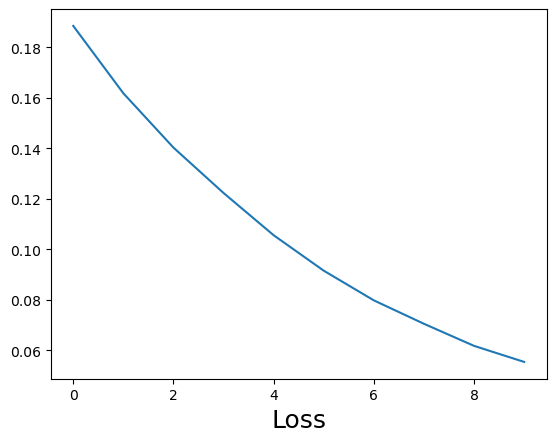

In [35]:
print(train_loss)
plt.plot(train_loss)
plt.xlabel('Epoch', size=18)

plt.xlabel('Loss', size=18)

plt.savefig('figures/wed_loss.png', dpi=200)


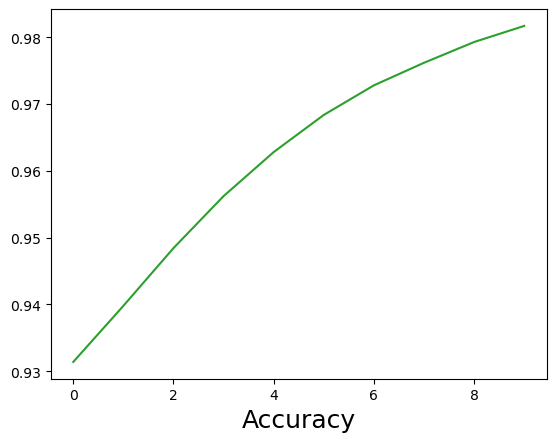

In [36]:
plt.plot(train_acc, color='tab:green')
plt.xlabel('Epoch', size=18)
plt.xlabel('Accuracy', size=18)
plt.savefig('figures/wed_accuracy.png', dpi=200)

In [ ]:
# model.save('model1')

In [ ]:
file_list[0]

'/Users/veraberger/nasa/training_data/267484897_47_2_data.npy'

In [89]:
file_list_pred

NameError: name 'file_list_pred' is not defined

 fluxes 1 labels 1 centroid 1 poscorr 1


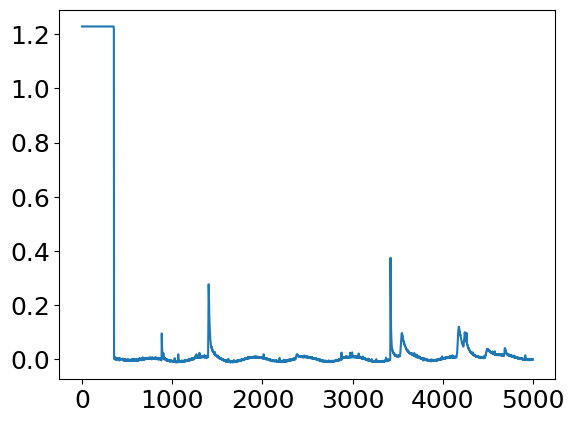

In [43]:
file_list_pred = file_list[12]
lcdata = np.load(file_list_pred).T
flux_list, label_list, centroid_list, poscorr_list, cr_list = prep_for_generator(lcdata, fname=None)

[sub_lc] =flux_list
[sub_centroid] = centroid_list
[sub_poscorr] = poscorr_list
[sub_cr] = cr_list
init_time = lcdata[0]

k = 5000
# take a k-sized section of the lc
sub_lc = sub_lc[:k]
sub_centroid = sub_centroid[:k]
sub_poscorr = sub_poscorr[:k]
sub_cr = sub_cr[:k]
plt.plot(sub_lc)

In [316]:
# # I haven't actually tested this
# score = model.evaluate([sub_lc, sub_centroid, sub_poscorr, sub_cr], verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [ ]:
# ntime = fill_time(init_time)
nflares = fill_gaps(init_time, ntime, flares, zeros=True)
nflares = pad(nflares)
nflares = nflares[:5500]

In [ ]:
plt.plot(sub_lc)
plt.show()

In [44]:
# !conda install ipywidgets --yes
# !conda install jupyter --yes

window_size=700
preds = np.zeros(len(sub_lc))
print(len(preds))
for i in range(len(sub_lc)-window_size):
# for i in tqdm(range(len(sub_lc)-window_size)):
    lc_slice = sub_lc[i:i+window_size]
    centroid_slice = sub_centroid[i:i+window_size]
    poscorr_slice = sub_poscorr[i:i+window_size]
    cr_slice = sub_cr[i:i+window_size]
    preds[i+int(window_size/2)] = model.predict([lc_slice.reshape(1,window_size,1), 
                                                 centroid_slice.reshape(1,window_size,1), 
                                                poscorr_slice.reshape(1,window_size,1), 
                                                cr_slice.reshape(1,window_size,1)], 
                                                verbose=0
                                               )

5000


In [ ]:


# sub_lc = lc_list[0][:15000]
# preds = np.zeros(len(sub_lc))
# for i in tqdm(range(len(sub_lc)-window_size)):
#   lc_slice = sub_lc[i:i+window_size]
#   #plt.scatter(lc_slice.time.value, lc_slice.flux.value, c = y[(idx+i-int(num_preds/2)-int(window_size/2)) : (idx+i-int(num_preds/2)+int(window_size/2))])
#   #plt.show()
#   preds[i+int(window_size/2)] = model.predict(lc_slice.reshape(1,window_size,1), verbose=0)


In [45]:
print(sum(preds), '* max pred', preds.max(), '* min pred', preds.min(), '* median pred', np.median(preds))

3270.755655685789 * max pred 1.0 * min pred 0.0 * median pred 0.8907025754451752


In [ ]:
model.save('monmodel.h5')

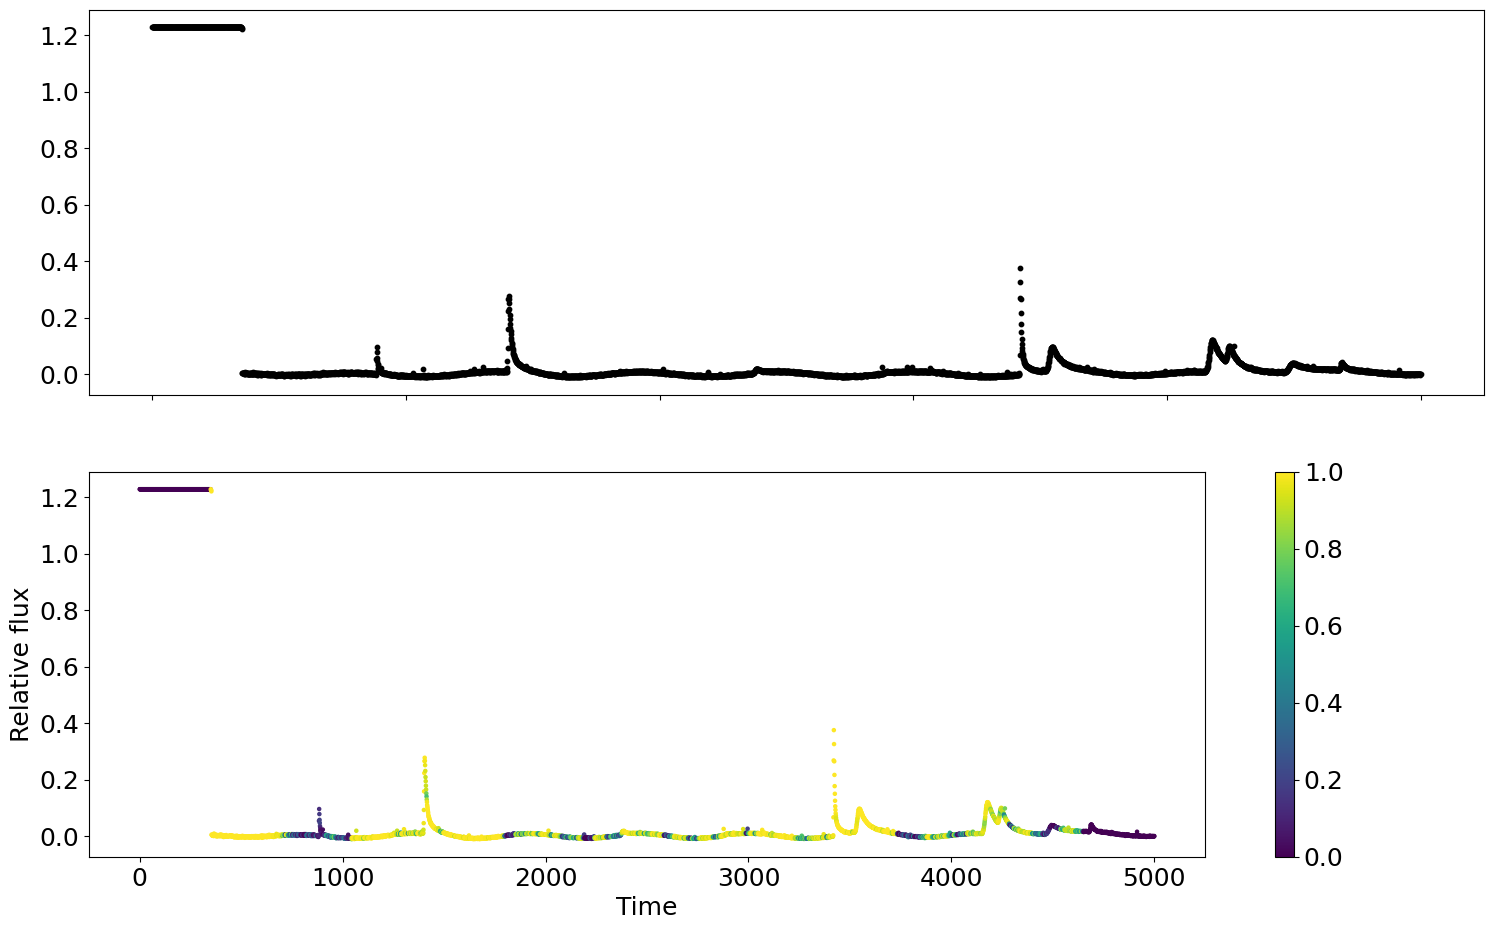

In [46]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
fig, ax = plt.subplots(2, figsize=(18,11), sharex=True, sharey=True)
ax[0].scatter(np.linspace(0, len(sub_lc), len(sub_lc)), sub_lc, c='black', s=10)
# ax[0].scatter(np.linspace(0, len(sub_lc), len(sub_lc)), sub_lc, c=nflares, cmap='viridis', s=10)
mappable = ax[1].scatter(np.linspace(0, (len(sub_lc)), len(sub_lc)), sub_lc, c=preds, cmap='viridis', s=5)
plt.colorbar(mappable)
# ax[0].set_ylim(-.03, 0.25)
# ax[0].set_xlim(500, 5350)
ax[1].set_ylabel("Relative flux", size=18)
ax[1].set_xlabel("Time", size=18)
# fig.tick_params(labelsize=18)
# ax[0].set_xlim(20000, 45000)
# plt.savefig('figures/first_pred_idk.png', dpi=200, bbox_inches='tight', transparent=False)
plt.show()